# Tucker: Number of components. DIFFIT and BIC

In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl
from tensorly.cp_tensor import CPTensor
from tensorly.tucker_tensor import TuckerTensor, tucker_to_tensor
from tensorly.tenalg import multi_mode_dot
import math
from tensorly.decomposition import tucker, non_negative_tucker, non_negative_tucker_hals
from scipy.interpolate import interp1d
import tlviz
import matlab.engine
import scipy.io
import pyreadr
import rpy2

## Import tensors

In [14]:
tensor_70 = np.load('tensors/tensor_70.npy')
tensor_100 = np.load('tensors/tensor_100.npy')
tensor_200 = np.load('tensors/tensor_200.npy')
tensor_300 = np.load('tensors/tensor_300.npy')

### DIFFIT

In [331]:
best_ranks = []
best_fits = []
valid_ranks = []
tensor = tensor_300  # change tensor
model = non_negative_tucker # change model

for i in range(1, tensor.shape[0]+1):
    for j in range(1, tensor.shape[1]+1):
        for k in range(1, tensor.shape[2]+1):
            if i <= j*k and j <= i*k and k <= i*j:
                valid_ranks.append([i, j, k])

valid_ranks = np.array(valid_ranks)

unique_s = np.unique(np.sum(valid_ranks, axis=1))

for s in unique_s:
    ranks_s = valid_ranks[np.sum(valid_ranks, axis=1) == s]

    best_fit = 0
    best_rank = []

    for rank in ranks_s:
        core_tensor, factors = model(tensor, list(rank))

        reconstructed_tensor = tl.tucker_to_tensor((core_tensor, factors))

        fit = (np.sum(tensor**2) - np.sum((tensor - reconstructed_tensor)**2)) / np.sum(tensor**2)

        if fit > best_fit:
            best_fit = fit
            best_rank = rank

    best_ranks.append(best_rank)
    best_fits.append(best_fit)

In [332]:
#threshold
tensor = tensor_300
np.sum(tensor**2)/(tensor.shape[0]+tensor.shape[1]+tensor.shape[2]-3)

0.1358974983341603

In [330]:
df = pd.DataFrame(best_ranks, columns=['P', 'Q', 'R'])
df['Fit'] = best_fits
df.to_csv('best_ranks_and_fits.csv', index=False)

### BIC

In [333]:
def compute_BIC(tensor, core, factors, gamma):
    reconstructed_tensor = tl.tucker_to_tensor((core, factors))
    
    RSS = np.sum((tensor - reconstructed_tensor) ** 2)

    n = np.prod(tensor.shape)
    
    core_params = np.prod(core.shape)
    factor_params = sum([np.prod(f.shape) for f in factors])
    k = core_params + factor_params

    BIC = n * np.log(RSS / n) + gamma * k * np.log(n)

    return BIC

In [357]:
def bic_best_ranks(gamma_values, tensor, model):
    valid_ranks = []
    
    for i in range(1, tensor.shape[0] + 1):
        for j in range(1, tensor.shape[1] + 1):
            for k in range(1, tensor.shape[2] + 1):
                if i <= j * k and j <= i * k and k <= i * j and i + j + k <= 15:
                    valid_ranks.append([i, j, k])

    valid_ranks = np.array(valid_ranks)
    unique_s = np.unique(np.sum(valid_ranks, axis=1))

    gamma_ranks = []
    gamma_bics = []

    for gamma in gamma_values:
        best_ranks = []
        best_bics = []
        
        for s in unique_s:
            ranks_s = valid_ranks[np.sum(valid_ranks, axis=1) == s]

            best_bic = np.inf
            best_rank = []
        
            for rank in ranks_s:
                core_tensor, factors = model(tensor, list(rank))
                bic = compute_BIC(tensor, core_tensor, factors, gamma)

                if bic < best_bic:
                    best_bic = bic
                    best_rank = rank

            best_ranks.append(best_rank)
            best_bics.append(best_bic)

        gamma_ranks.append(best_ranks)
        gamma_bics.append(best_bics)

    return gamma_ranks, gamma_bics

In [389]:
# normal tucker
gamma_ranks_70, gamma_bics_70 = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_70, tucker)
gamma_ranks_100, gamma_bics_100 = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_100, tucker)
gamma_ranks_200, gamma_bics_200 = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_200, tucker)
gamma_ranks_300, gamma_bics_300 = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_300, tucker)

In [390]:
def visualize_gamma_lists(gamma_lists, x_values):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for idx, gamma_bics in enumerate(gamma_lists):
        ax = axes[idx] 

        for i, y_values in enumerate(gamma_bics):
            ax.plot(x_values, y_values, marker='o', label=f'gamma {i+1}')
        if idx == 0:
            idx = 0.7
        ax.set_xlabel('Number of components')
        ax.set_ylabel('BIC Value')
        ax.set_title(f'BIC Values for Tensor {int(idx*100)}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

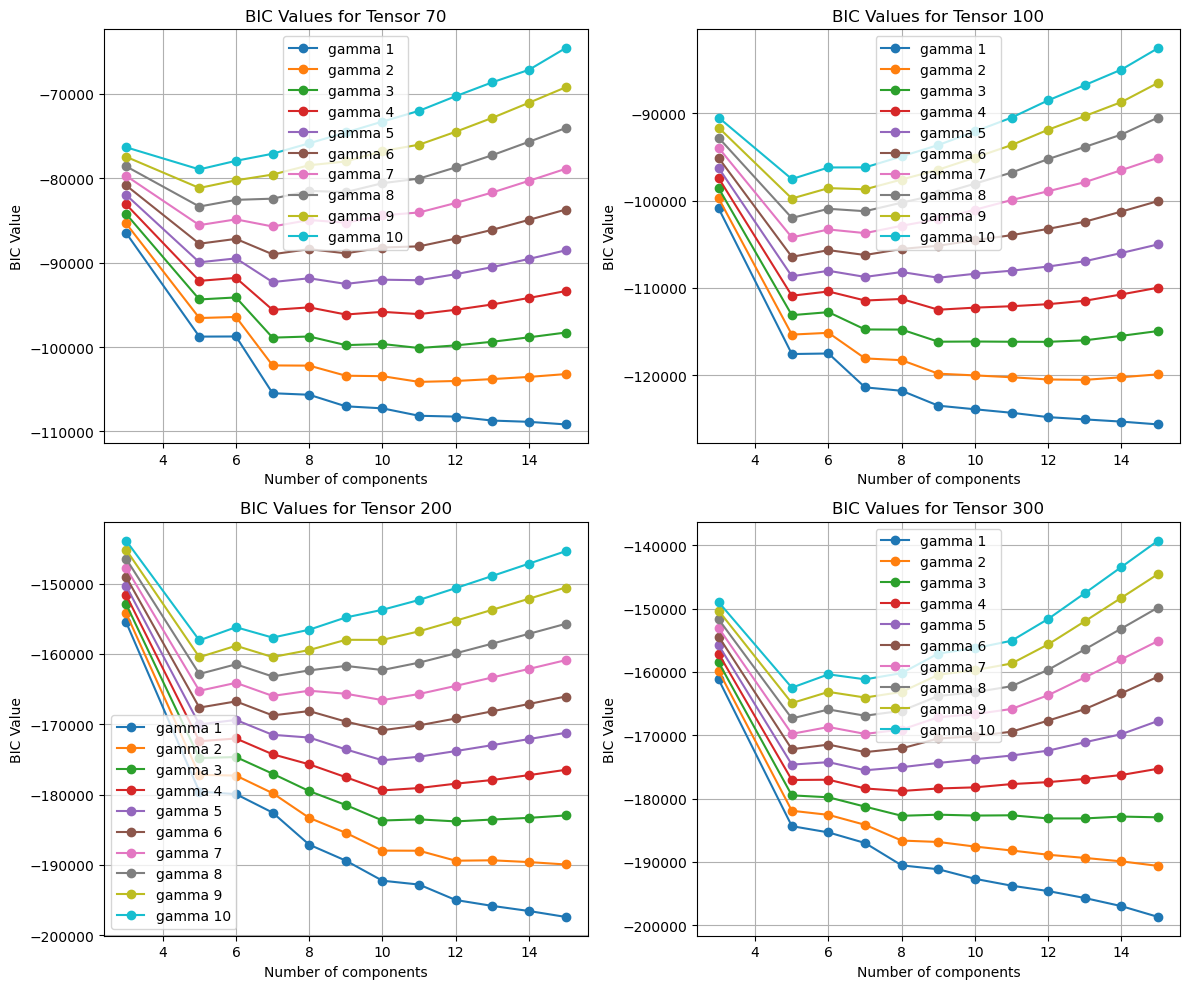

In [391]:
gamma_lists = [gamma_bics_70, gamma_bics_100, gamma_bics_200, gamma_bics_300]
x_values = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visualize_gamma_lists(gamma_lists, x_values)

In [393]:
for i in range(len(gamma_ranks_70)):
    print("For gamma {}, the best rank is {} for tensor_70, {} for tensor_100, {} for tensor_200 and {} for tensor_300.".format(i+1, gamma_ranks_70[i][gamma_bics_70[i].index(min(gamma_bics_70[i]))],gamma_ranks_100[i][gamma_bics_100[i].index(min(gamma_bics_100[i]))],gamma_ranks_200[i][gamma_bics_200[i].index(min(gamma_bics_200[i]))],gamma_ranks_300[i][gamma_bics_300[i].index(min(gamma_bics_300[i]))]))

For gamma 1, the best rank is [5 3 7] for tensor_70, [5 4 6] for tensor_100, [5 4 6] for tensor_200 and [6 3 6] for tensor_300.
For gamma 2, the best rank is [3 3 5] for tensor_70, [3 4 6] for tensor_100, [5 4 6] for tensor_200 and [5 4 6] for tensor_300.
For gamma 3, the best rank is [3 3 5] for tensor_70, [3 4 5] for tensor_100, [4 3 5] for tensor_200 and [4 3 5] for tensor_300.
For gamma 4, the best rank is [3 2 4] for tensor_70, [3 2 4] for tensor_100, [3 3 4] for tensor_200 and [3 2 3] for tensor_300.
For gamma 5, the best rank is [3 2 4] for tensor_70, [3 2 4] for tensor_100, [3 3 4] for tensor_200 and [2 2 3] for tensor_300.
For gamma 6, the best rank is [3 1 3] for tensor_70, [2 1 2] for tensor_100, [3 3 4] for tensor_200 and [2 2 3] for tensor_300.
For gamma 7, the best rank is [3 1 3] for tensor_70, [2 1 2] for tensor_100, [3 3 4] for tensor_200 and [2 2 3] for tensor_300.
For gamma 8, the best rank is [2 1 2] for tensor_70, [2 1 2] for tensor_100, [2 2 3] for tensor_200 and 

In [394]:
# non-negative tucker
gamma_ranks_70_nn, gamma_bics_70_nn = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_70, non_negative_tucker)
gamma_ranks_100_nn, gamma_bics_100_nn = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_100, non_negative_tucker)
gamma_ranks_200_nn, gamma_bics_200_nn = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_200, non_negative_tucker)
gamma_ranks_300_nn, gamma_bics_300_nn = bic_best_ranks([1,2,3,4,5,6,7,8,9,10], tensor_300, non_negative_tucker)

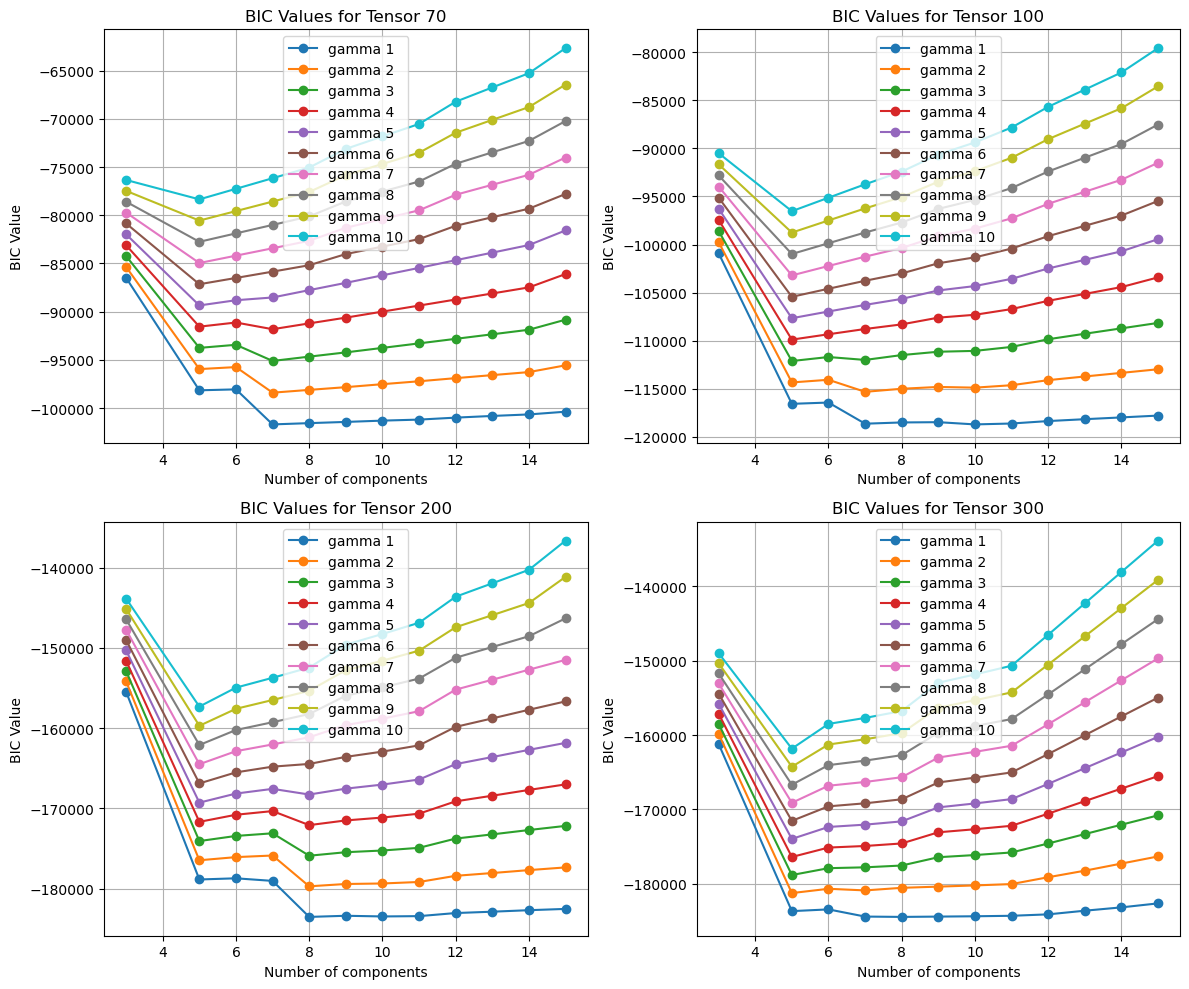

In [395]:
gamma_lists = [gamma_bics_70_nn, gamma_bics_100_nn, gamma_bics_200_nn, gamma_bics_300_nn]
x_values = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visualize_gamma_lists(gamma_lists, x_values)

In [396]:
for i in range(len(gamma_ranks_70_nn)):
    print("For gamma {}, the best rank is {} for tensor_70, {} for tensor_100, {} for tensor_200 and {} for tensor_300.".format(i+1, gamma_ranks_70_nn[i][gamma_bics_70_nn[i].index(min(gamma_bics_70_nn[i]))],gamma_ranks_100_nn[i][gamma_bics_100_nn[i].index(min(gamma_bics_100_nn[i]))],gamma_ranks_200_nn[i][gamma_bics_200_nn[i].index(min(gamma_bics_200_nn[i]))],gamma_ranks_300_nn[i][gamma_bics_300_nn[i].index(min(gamma_bics_300_nn[i]))]))

For gamma 1, the best rank is [3 1 3] for tensor_70, [3 2 5] for tensor_100, [3 2 3] for tensor_200 and [3 2 3] for tensor_300.
For gamma 2, the best rank is [3 1 3] for tensor_70, [3 1 3] for tensor_100, [3 2 3] for tensor_200 and [2 1 2] for tensor_300.
For gamma 3, the best rank is [3 1 3] for tensor_70, [2 1 2] for tensor_100, [3 2 3] for tensor_200 and [2 1 2] for tensor_300.
For gamma 4, the best rank is [3 1 3] for tensor_70, [2 1 2] for tensor_100, [3 2 3] for tensor_200 and [2 1 2] for tensor_300.
For gamma 5, the best rank is [2 1 2] for tensor_70, [2 1 2] for tensor_100, [2 1 2] for tensor_200 and [2 1 2] for tensor_300.
For gamma 6, the best rank is [2 1 2] for tensor_70, [2 1 2] for tensor_100, [2 1 2] for tensor_200 and [2 1 2] for tensor_300.
For gamma 7, the best rank is [2 1 2] for tensor_70, [2 1 2] for tensor_100, [2 1 2] for tensor_200 and [2 1 2] for tensor_300.
For gamma 8, the best rank is [2 1 2] for tensor_70, [2 1 2] for tensor_100, [2 1 2] for tensor_200 and 